In [462]:
import pandas as pd
import spacy
import ast
import re
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn import linear_model
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import sparse
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend([u'like',u'ad', u'let', u'add', u'team', u'able',u'library', u'hear', u'thing', u'really', u'continue', u'job', u'everyday', u'basic', u'choice', u'lil', u'month', u'save', u'come', u'ever', u'guy', u'keep', u'wifi', u'sometimes', u'artist', u'selection', u'choose', u'always', u'nothing', u'tablet', u'range', u'know', u'follow', u'daily', u'overall', u'give', u'totally', u'life', u'anything', u'everything', u'never', u'spotify', u'think', u'also', u'many', u'stuff', u'second', u'could', u'try', u'still', u'must', u'need', u'away', u'day', u'bit', u'number', u'make',u'year', u'lot', u'time',u'buy', u'song', u'even', u'minute', u'phone', u'gemitin', u'basta', u'say', u'everyone', u'service', u'take', u'bottom', u'panget', u'otherwise', u'yet', u'put', u'much', u'far', u'thank',  u'-PRON-', u'go', u'play',u'app', u'from', u'subject', u're', u'edu', u'use',  u'album', u'get', u'would', u'already',u'xe',u'vez', u'include', u'litt', u'sort', u'dayu', u'nice', u'dont', u'i', u'want', u'that'])

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import warnings



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yubozhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [463]:


reviews = []
with open('scraped_reviews_spotify2.txt', 'r') as f: #, encoding='utf-8'
    reviews = f.read()

reviews = re.sub('\]', '', reviews)
reviews = re.sub('\[', '', reviews)
reviews = re.sub('\n', '', reviews)
reviews = re.sub("'", '"', reviews)
reviews = re.sub('    ', ' ', reviews)
reviews = re.sub(' {', '{', reviews)
reviews = re.sub(' }', '}', reviews)
reviews = re.sub('{ ', '{', reviews)
reviews = re.sub('} ', '}', reviews)
reviews = re.sub('}  {', '}, {', reviews)
reviews = re.sub('}{', '}, {', reviews)
reviews = re.sub('id:', '"id":', reviews)
reviews = re.sub('userName:', '"userName":', reviews)
reviews = re.sub('userImage:', '"userImage":', reviews)
reviews = re.sub('date:', '"date":', reviews)
reviews = re.sub('url:', '"url":', reviews)
reviews = re.sub('score:', '"score":', reviews)
reviews = re.sub('title:', '"title":', reviews)
reviews = re.sub('text:', '"text":', reviews)
reviews = re.sub('replyDate:', '"replyDate":', reviews)
reviews = re.sub('replyText:', '"replyText":', reviews)
reviews = re.sub(': undefined', ': "undefined"', reviews)

In [464]:
review_strings = [r+'}' for r in reviews.split('},')]
review_strings[-1] = review_strings[-1][:-1]

In [465]:
review_list = []
for r in review_strings:
    try:
        review_list.append(json.loads(r))
    except:
        pass

In [472]:
raw_dates = []
for i in range(len(review_list)): # change to larger number
    raw_dates.append(review_list[i][u'date'])

In [473]:
raw_dates

[u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'November 4, 2018',
 u'Novembe

In [466]:
raw_scores = []
for i in range(len(review_list)): # change to larger number
    raw_scores.append(review_list[i][u'score'])

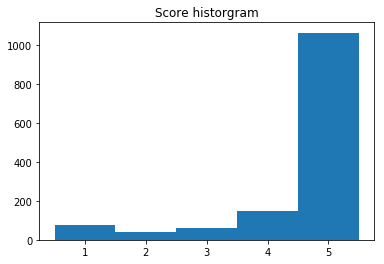

In [467]:
plt.title('Score historgram')
a = plt.hist(raw_scores, bins=[.5, 1.5, 2.5, 3.5,4.5,5.5])
plt.show()

In [468]:
def remove_stopwords(texts, stop_words):
    corp=[]
    for doc in texts:
        fix_doc=[]
        for word in doc:
            if word not in stop_words:
                fix_doc.append(word)
        corp.append(fix_doc)
    return corp
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        if sent != []:
            doc = nlp(" ".join(sent)) 

            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
 
    return texts_out

In [469]:
#Lets devide the data by scores
corpuses = {}
id2words = {}
models={}
for score in range(1,6):
#score = 1
#choseScore = [raw_score==score for raw_score in raw_scores]
    review_list_s = []
    for i in range(len(review_list)): 
        if raw_scores[i]==score:
            review_list_s.append(review_list[i])
    raw_corpus = []
    for i in range(len(review_list_s)): # change to larger number
        raw_corpus.append(review_list_s[i][u'text'])
    data = raw_corpus
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    data = [re.sub("\"", "", sent) for sent in data]
    data = [re.sub("_", "", sent) for sent in data]
    
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str([sentence]), deacc=True)) 
            
    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    data_words_nostops = remove_stopwords(data_lemmatized, stop_words)
    data_words_bigrams = make_bigrams(data_words_nostops)

    data_lemmatized = data_words_bigrams

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    
    warnings.filterwarnings("ignore",category=DeprecationWarning)

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=3, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    models[score]=lda_model
    corpuses[score]=corpus
    id2words[score]=id2word

In [470]:
for i in range(1,6):
    print '\nTopics with score ',i
    print 'Ocurs ', float(a[0][i-1])/float(sum(a[0])), ' of the time.'
    print models[i].print_topics()
   


Topics with score  1
Ocurs  0.0539568345324  of the time.
[(0, u'0.022*"listen" + 0.020*"change" + 0.020*"music" + 0.020*"hate" + 0.017*"playlist" + 0.017*"log" + 0.014*"update" + 0.014*"horrible" + 0.012*"premium" + 0.012*"bad"'), (1, u'0.019*"playlist" + 0.016*"open" + 0.014*"uninstall" + 0.014*"version" + 0.014*"pay" + 0.011*"music" + 0.011*"listen" + 0.011*"limit" + 0.011*"local" + 0.010*"premium"'), (2, u'0.018*"premium" + 0.017*"slow" + 0.017*"playlist" + 0.014*"work" + 0.014*"update" + 0.014*"shuffle" + 0.012*"listen" + 0.012*"load" + 0.012*"music" + 0.009*"problem"')]

Topics with score  2
Ocurs  0.0280575539568  of the time.
[(0, u'0.021*"update" + 0.016*"start" + 0.016*"offline" + 0.013*"good" + 0.011*"pay" + 0.011*"music" + 0.011*"search" + 0.011*"home" + 0.011*"subscription" + 0.011*"recent"'), (1, u'0.022*"good" + 0.017*"page" + 0.017*"happen" + 0.017*"radio" + 0.017*"different" + 0.017*"music" + 0.017*"free" + 0.017*"freeze" + 0.017*"pay" + 0.017*"premium"'), (2, u'0.026

In [471]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Visualize the topics
score =1
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[score], corpuses[score], id2words[score])
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      34.451054        1       1 -0.100489  0.005152
2      32.781914        1       2  0.045314 -0.081327
0      32.767036        1       3  0.055175  0.076175, topic_info=     Category      Freq        Term      Total  loglift  logprob
term                                                            
204   Default  4.000000        slow   4.000000  30.0000  30.0000
355   Default  4.000000         log   4.000000  29.0000  29.0000
149   Default  4.000000        open   4.000000  28.0000  28.0000
233   Default  3.000000    horrible   3.000000  27.0000  27.0000
24    Default  3.000000     version   3.000000  26.0000  26.0000
30    Default  6.000000      change   6.000000  25.0000  25.0000
370   Default  3.000000       limit   3.000000  24.0000  24.0000
209   Default  3.000000       local   3.000000  23.0000  23.0000
97    Default  5.000000   uninstall   5.000000  22.0000  22.0000
41    Default  4.000000     shuffle   4.000000  21.0000  21.0000
218   Default  3.000000         bad   3.000000  20.0000  20.0000
247   Default  2.000000       login   2.000000  19.0000  19.0000
309   Default  2.000000         big   2.000000  18.0000  18.0000
16    Default  2.000000       force   2.000000  17.0000  17.0000
141   Default  2.000000       place   2.000000  16.0000  16.0000
281   Default  2.000000    annoying   2.000000  15.0000  15.0000
1     Default  7.000000        hate   7.000000  14.0000  14.0000
61    Default  2.000000     account   2.000000  13.0000  13.0000
284   Default  5.000000         pay   5.000000  12.0000  12.0000
329   Default  3.000000      people   3.000000  11.0000  11.0000
332   Default  3.000000        back   3.000000  10.0000  10.0000
0     Default  3.000000        skip   3.000000   9.0000   9.0000
259   Default  3.000000          pc   3.000000   8.0000   8.0000
20    Default  3.000000    download   3.000000   7.0000   7.0000
62    Default  5.000000        work   5.000000   6.0000   6.0000
386   Default  3.000000      longer   3.000000   5.0000   5.0000
117   Default  3.000000        edit   3.000000   4.0000   4.0000
85    Default  3.000000        suck   3.000000   3.0000   3.0000
240   Default  3.000000      screen   3.000000   2.0000   2.0000
249   Default  3.000000       whole   3.000000   1.0000   1.0000
...       ...       ...         ...        ...      ...      ...
251    Topic3  0.861713     battery   1.297742   0.7063  -5.6248
202    Topic3  0.861709  chromebook   1.297743   0.7063  -5.6248
121    Topic3  0.861706   bluetooth   1.297743   0.7063  -5.6248
116    Topic3  0.861704   everytime   1.297743   0.7063  -5.6248
216    Topic3  0.861699         bar   1.297743   0.7063  -5.6248
179    Topic3  0.861693      combat   1.297743   0.7063  -5.6248
131    Topic3  0.861683      trashy   1.297743   0.7063  -5.6248
246    Topic3  0.861680     atleast   1.297743   0.7062  -5.6248
259    Topic3  2.154833          pc   3.250794   0.7046  -4.7082
20     Topic3  2.151517    download   3.250798   0.7030  -4.7098
1      Topic3  4.699296        hate   7.791588   0.6101  -3.9285
156    Topic3  5.327008      listen  11.053623   0.3858  -3.8031
260    Topic3  2.155589       waste   3.898257   0.5233  -4.7079
0      Topic3  2.146424        skip   3.885463   0.5223  -4.7121
50     Topic3  4.720591       music  10.407499   0.3252  -3.9240
306    Topic3  1.508401         hat   2.591567   0.5745  -5.0649
235    Topic3  1.505881       email   2.591619   0.5728  -5.0665
225    Topic3  1.508395       close   2.604428   0.5696  -5.0649
180    Topic3  1.508268       track   2.604441   0.5695  -5.0650
219    Topic3  1.506557      stupid   2.604475   0.5683  -5.0661
129    Topic3  1.505187     offline   2.604440   0.5674  -5.0670
383    Topic3  3.448361      update   8.441178   0.2205  -4.2380
222    Topic3  2.155215         see   4.558599   0.3666  -4.7080
151    Topic3  4.093171    playlist  13.036792 